In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("customers_churn.csv")

In [3]:
data.dtypes

,0
State,object
Account_Length,int64
Area_Code,int64
Phone,object
Intl_Plan,object
VMail_Plan,object
VMail_Message,int64
Day_Mins,float64
Day_Calls,int64
Day_Charge,float64


In [4]:
# Remove the State and Phone categoricals, separate y from X
X = data.drop(columns=["Churn", "State", "Phone"])
y = data["Churn"]

In [24]:
# Convert "yes" to 1 and "no" to 0 in VMail_Plan, Intl_Plan features
#
# your code here...

X['VMail_Plan'] = X['VMail_Plan'].map({'yes': 1, 'no': 0})
X['Intl_Plan'] = X['Intl_Plan'].map({'yes': 1, 'no': 0})

In [25]:
y.value_counts()

,count
Churn,
0,2850
1,483


As you can see, this is an unbalanced dataset with "0" (negative) rate of 85%.
This means that whatever we get from the learning algorithm, if it is less than 85% then it is worthless, because we could get that simply by predicting "0".

In [31]:
# Split dataset into training set and test set with 70%-30%

# ...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # YOUR CODE HERE

In [32]:
# Create Decision Tree classifier object - no restrictions for now
clf = DecisionTreeClassifier()

# Your code below - fit the model
#...
tree = clf.fit(X_train,y_train)

In [33]:
# Print the test accuracy and the train accuracy
# your code here
# ...
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

y_pred_train = clf.predict(X_train)
print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.894
Train Accuracy: 1.0


There is probably a bit of overfitting.  Let us view the tree.

In [34]:
from sklearn.tree import export_graphviz
import pydotplus

# This will create a .dot file, which is a standard for representing trees.
# Feel free to open it and view it (it is textual)
export_graphviz(tree, out_file="tree.dot",
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X_train.columns,
                class_names=['0','1'])
import pydotplus # for viewing .dot files
pydotplus.graph_from_dot_file("tree.dot").write_png('tree.png')

True

### Inspecting the tree visually
Open the file tree.png that was created, and view it with your favorite viewer.  The resulting tree is extremely complex, and you may need a zoom-in tool to see what's going on.  The first thing to note is that the algorithm uses the "gini" index to decide whether to split a node.  Each node in the tree is annotated with the Gini index. This is because by default, the algorithm uses the "gini" criterion.  If you look at the documentation, you shall see that this criterion can be changed in the arguments of DecisionTreeClassifier, using the keyword criterion="entropy" for Information Gain as we learned in class.  
Additionally, each node is also annotated with the number of training examples falling in the region defined by the node, and also with a count of the number of "0" and number of "1"'s in the training set in that region ("value" in the picture), which can be used for soft prediction. Finally you will see "class" which is the hard prediction.
 If you inspect the leaves, you will see that they are all pure, which happens because we enforced no limits on the output tree.

To fight the overfitting, we may want to limit the tree in some way.  max_depth is a typical way.  Let's try it.

In [36]:
# Create Decision Tree classifier object with depth at most 4
clf = DecisionTreeClassifier(max_depth = 4)
# Your code below
tree = clf.fit(X_train, y_train)
# Predict on test and train data
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Evaluate the model
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Train Accuracy:", metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.943
Train Accuracy: 0.954564937848264


In [37]:
export_graphviz(tree, out_file="tree2.dot",
                filled=True, rounded=True,
                special_characters=True,
                class_names=['0','1'],
                feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_file("tree2.dot").write_png('tree2.png')
# View the resulting tree2.png, compare to tree.png

Let's look at the training and validation error.

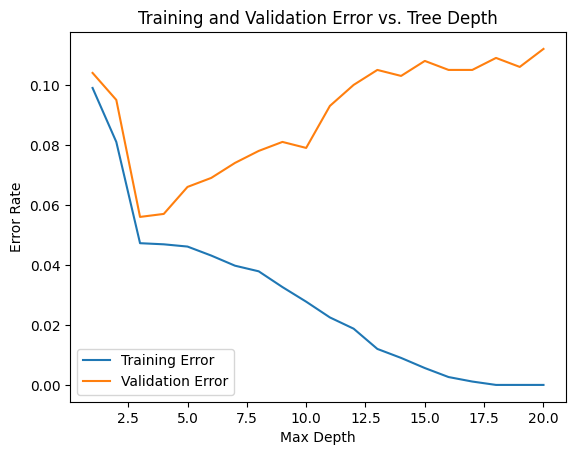

In [42]:
# Your code here for printing training and validation error
# Create Decision Tree classifier objects with different depths
depths = range(1, 21)
train_errors = []
validation_errors = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_error = 1 - metrics.accuracy_score(y_train, y_pred_train)
    validation_error = 1 - metrics.accuracy_score(y_test, y_pred_test)

    train_errors.append(train_error)
    validation_errors.append(test_error)

# Plotting the errors
plt.plot(depths, train_errors, label='Training Error')
plt.plot(depths, test_errors, label='Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.title('Training and Validation Error vs. Tree Depth')
plt.legend()
plt.show()

### The sweet spot plot: Visualizing overfitting
In this exercise we will go back to the binary classification problem, and we shall vary the max-depth parameter from 1 to 20. For each value of max-depth, we will run k-fold cross validation on the decision tree classifier, in order to get a low-variance estimate of both the training and of the validation error.  Finally, we will plot both the training and validation errors and see what we get.

We will use sklean's model_selection.KFold for performing the K-fold management.  There are other options, for example model_selection.cross_val_score, but the "KFold" option gives us low-level control over the process, which we need for this case.

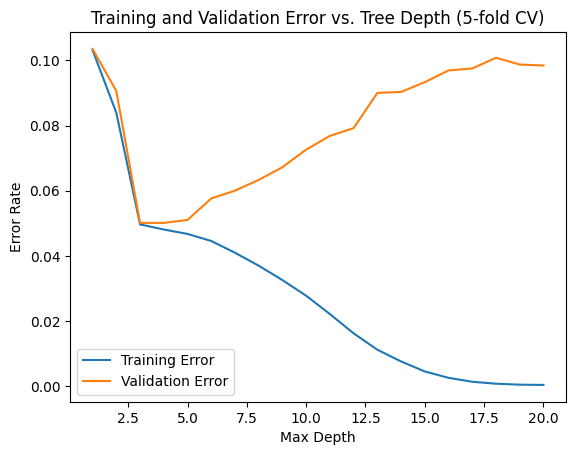

In [48]:
from sklearn.model_selection import KFold
# Define the number of folds for cross-validation
n_splits = 5

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

depths = range(1, 21)
train_errors = []
validation_errors = []

for depth in depths:
    train_errors_depth = []
    validation_errors_depth = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train_fold, y_train_fold)

        y_pred_train = clf.predict(X_train_fold)
        y_pred_val = clf.predict(X_val_fold)

        train_error = 1 - metrics.accuracy_score(y_train_fold, y_pred_train)
        validation_error = 1 - metrics.accuracy_score(y_val_fold, y_pred_val)

        train_errors_depth.append(train_error)
        validation_errors_depth.append(validation_error)

    train_errors.append(np.mean(train_errors_depth))
    validation_errors.append(np.mean(validation_errors_depth))

# Plotting the errors
plt.plot(depths, train_errors, label='Training Error')
plt.plot(depths, validation_errors, label='Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.title('Training and Validation Error vs. Tree Depth (5-fold CV)')
plt.legend()
plt.show()

## Write down your conclusions, insights, and further ideas below

# Understanding the Dataset
The dataset represents customer churn, where the target variable (Churn) indicates whether a customer left the service (1) or stayed (0).<br>
There is a clear class imbalance:


*   85% of customers did not churn (0).
*   15% of customers churned (1).

This means a model could achieve 85% accuracy just by predicting 0 all the time, making accuracy alone a poor metric for evaluation.


# Preprocessing Steps and Model Training
##Feature Selection & Transformation:

Removed categorical features like "State" and "Phone" since they may not provide useful information.
Converted "yes"/"no" values in "VMail_Plan" and "Intl_Plan" into numerical 1 and 0 for easier model training.
##Decision Tree Classifier (First Attempt)


*   Training Accuracy: 100% (overfitting!)
*   Test Accuracy: 89.6%


The model is too complex and memorizes the training data, leading to poor generalization.

##Decision Tree Classifier (With max-depth = 4)

Training Accuracy: 95.4%
Test Accuracy: 94.3%
Setting a maximum depth reduced overfitting and improved generalization.

# Insights from Overfitting Analysis
## Tree Complexity and Error Rate:

A deep tree results in perfect training accuracy but struggles on unseen data.
Limiting the depth to 4 helped balance training and test performance.
Validation errors increased beyond depth 5, reinforcing the need for regularization.
## K-Fold Cross-Validation Findings:

5-Fold Cross-Validation provided a more reliable estimate of test performance.
Validation errors showed that simpler models generalize better.
# Further Ideas for Improvement

## Handling Class Imbalance



*   SMOTE (Synthetic Minority Over-sampling Technique): Generate synthetic churn samples to balance the dataset.
*   Class Weights: Assign higher importance to churn cases to prevent the model from favoring the majority class.




## Feature Engineering
*   Customer Lifetime Value (CLV): Estimate long-term revenue contribution of each customer.
*   Interaction Features: Create new features based on relationships between existing ones.



## Try Alternative Models
*   Random Forests: An ensemble of decision trees, reducing overfitting.
*   Gradient Boosting (XGBoost, LightGBM): More advanced techniques for better performance.



## Hyperparameter Tuning
*   Optimize max_depth, min_samples_split, and min_samples_leaf to find the best decision tree configuration.


In [53]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("customers_churn.csv")

# Remove categorical features that are not useful
X = df.drop(columns=["Churn", "State", "Phone"])
y = df["Churn"]

# Convert 'yes'/'no' to binary values
X['VMail_Plan'] = X['VMail_Plan'].map({'yes': 1, 'no': 0})
X['Intl_Plan'] = X['Intl_Plan'].map({'yes': 1, 'no': 0})

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models and evaluate performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Accuracy (Train)": accuracy_score(y_train, y_train_pred),
        "Accuracy (Test)": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1 Score": f1_score(y_test, y_test_pred),
        "ROC AUC": roc_auc_score(y_test, y_test_pred)
    }
    return metrics

# Logistic Regression
log_model = LogisticRegression()
log_results = evaluate_model(log_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test)

# Display results
model_performance = pd.DataFrame({
    "Metric": ["Accuracy (Train)", "Accuracy (Test)", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "Logistic Regression": list(log_results.values()),
    "Random Forest": list(rf_results.values()),
    "Gradient Boosting": list(gb_results.values())
})

from IPython.display import display

# Display results
display(model_performance)


,Metric,Logistic Regression,Random Forest,Gradient Boosting
0,Accuracy (Train),0.758991,0.833991,0.946272
1,Accuracy (Test),0.742105,0.827193,0.931579
2,Precision,0.718593,0.976064,0.981818
3,Recall,0.772973,0.661261,0.875676
4,F1 Score,0.744792,0.788400,0.925714
5,ROC AUC,0.742897,0.822938,0.930146
